In [1]:
# %preprocess physiological data files%
# compute values of zyg, cog, scr for each trigger in each trial
# combine physiological values to behavioral data file (one row per trial)
# coding=utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pyphysio.pyphysio import signal, filters, segmenters, interactive
from pyphysio.pyphysio.specialized.eda import DriverEstim, PhasicEstim, preset_phasic
from pyphysio.pyphysio.specialized.emg._presets import preset_femg

Using dask. Scheduler: threads
Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [2]:
### constant.py file ###
# manually delete the blank rows and the 4th column in "DACFE_trigger.csv" file
triggers = pd.read_csv('DACFE_trigger.csv', header=0)
triggers["Binary"] = triggers["Binary"].astype(int) * 5
triggers["binary"] = triggers["Binary"].astype(str).str.zfill(8)
for i in range(triggers.shape[0]):
    triggers.loc[i,"binary"] = triggers.loc[i, "binary"][::-1]  # start, stop, stepsize = -1

In [3]:
# would be assigned in loop.py file
datafile = "E:\Dissertation\Methods\Exp2_Demand_Choice\Analysis\Exp2_data2\\007\Data\\007.txt"

In [4]:
### physios.py file ###
# load data
col_names = ["zyg","scr","cor","trg1","trg2","trg3","trg4","trg5","trg6","trg7","trg8","na"]
data = pd.read_csv(datafile, sep='\t', names = col_names, index_col=False)
data['line'] = np.array(list(np.linspace(0, data.shape[0]-1, data.shape[0])), int)
data["binary"] = data.trg1.astype(str) + data.trg2.astype(str) + data.trg3.astype(str) + \
data.trg4.astype(str) + data.trg5.astype(str) + data.trg6.astype(str) + \
data.trg7.astype(str) + data.trg8.astype(str)

In [5]:
### physios.py file ###
df = data.merge(triggers, on="binary").drop(["Binary"], axis=1).sort_values(by='line')

In [ ]:
def sep_phases(df, phase_names):
    df['Phase'] = ''
    line_idxs = {}
    for phase in phase_names:
        line_i = np.where(df['TriggerName']== phase)[0][0]
        line_n = df.line.iloc[line_i]
        line_idxs[phase]=line_n
    # Practice Start
    df.loc[df.line.isin(range(line_idxs['prac2BackStart'],line_idxs['caliStart'])),'Phase'] = "Practice2Back"
    df.loc[df.line.isin(range(line_idxs['caliStart'],line_idxs['prac1BackStart'])),'Phase'] = "Calibration"
    df.loc[df.line.isin(range(line_idxs['prac1BackStart'],line_idxs['prac3BackStart'])),'Phase'] = "Practice1Back"
    df.loc[df.line.isin(range(line_idxs['prac3BackStart'],line_idxs['testStart'])),'Phase'] = "Practice3Back"
    # Test Start
    df.loc[df.line.isin(range(line_idxs['offlineT0Start'],line_idxs['learningStart'])),'Phase'] = "OfflineRatingT0"
    df.loc[df.line.isin(range(line_idxs['learningStart'],line_idxs['offlineT1Start'])),'Phase'] = "Learning"
    df.loc[df.line.isin(range(line_idxs['offlineT1Start'],line_idxs['trueChoiceStart'])),'Phase'] = "OfflineRatingT1"
    df.loc[df.line.isin(range(line_idxs['trueChoiceStart'],line_idxs['offlineT2Start'])),'Phase'] = "TrueChoice"
    
    df.loc[df.line.isin(range(line_idxs['offlineT2Start'],line_idxs['learningCheckT1Start'])),'Phase'] = "OfflineRatingT2"
    df.loc[df.line.isin(range(line_idxs['learningCheckT1Start'],line_idxs['falseChoiceStart'])),'Phase'] = "LearningCheckT1"
    df.loc[df.line.isin(range(line_idxs['falseChoiceStart'],line_idxs['offlineT3Start'])),'Phase'] = "FalseChoice"
    df.loc[df.line.isin(range(line_idxs['offlineT3Start'],line_idxs['learningCheckT2Start'])),'Phase'] = "OfflineRatingT3"
    df.loc[df.line.isin(range(line_idxs['learningCheckT2Start'],line_idxs['demandRatingStart'])),'Phase'] = "LearningCheckT2"
    # Demand Manipulation Check
    df.loc[df.line.isin(range(line_idxs['demandRatingStart'],line_idxs['expEnd'])),'Phase'] = "DemandRating"
    # separate phases
    df_learning = df[df['Phase'] == "Learning"].copy().sort_values('line')
    df_true_choice = df[df['Phase'] == "TrueChoice"].copy().sort_values('line')
    df_false_choice = df[df['Phase'] == "FalseChoice"].copy().sort_values('line')
    df_offlines = df[df['Phase'].str.startswith("OfflineRating")].copy().sort_values('line')
    df_learning_checks = df[df['Phase'].str.startswith("LearningCheck")].copy().sort_values('line')
    df_demand_ratings = df[df['Phase'] == "DemandRating"].copy().sort_values('line')
    # combine into a dict
    df_physios_raw = {'Learning':df_learning, 'TrueChoice':df_true_choice, 'FalseChoice':df_false_choice, 'Offlines':df_offlines,
                     'LearningCheck':df_learning_checks, 'DemandRating':df_demand_ratings}
    return df_physios_raw

In [6]:
### physios.py file ###
phase_names = list(triggers['TriggerName'][triggers['TriggerName'].str.endswith(("Start", "End"))])
# phase_names

In [7]:
### physios.py file ###
df['Phase'] = ''
line_idxs = {}
for phase in phase_names:
    line_i = np.where(df['TriggerName']== phase)[0][0]
    line_n = df.line.iloc[line_i]
#     print(phase, line_i)
    line_idxs[phase]=line_n
# line_idxs

In [8]:
### physios.py file ###
# Practice Start
df.loc[df.line.isin(range(line_idxs['prac2BackStart'],line_idxs['caliStart'])),'Phase'] = "Practice2Back"
df.loc[df.line.isin(range(line_idxs['caliStart'],line_idxs['prac1BackStart'])),'Phase'] = "Calibration"
df.loc[df.line.isin(range(line_idxs['prac1BackStart'],line_idxs['prac3BackStart'])),'Phase'] = "Practice1Back"
df.loc[df.line.isin(range(line_idxs['prac3BackStart'],line_idxs['testStart'])),'Phase'] = "Practice3Back"
# Test Start
df.loc[df.line.isin(range(line_idxs['offlineT0Start'],line_idxs['learningStart'])),'Phase'] = "OfflineRatingT0"
df.loc[df.line.isin(range(line_idxs['learningStart'],line_idxs['offlineT1Start'])),'Phase'] = "Learning"
df.loc[df.line.isin(range(line_idxs['offlineT1Start'],line_idxs['trueChoiceStart'])),'Phase'] = "OfflineRatingT1"
df.loc[df.line.isin(range(line_idxs['trueChoiceStart'],line_idxs['offlineT2Start'])),'Phase'] = "TrueChoice"

df.loc[df.line.isin(range(line_idxs['offlineT2Start'],line_idxs['learningCheckT1Start'])),'Phase'] = "OfflineRatingT2"
df.loc[df.line.isin(range(line_idxs['learningCheckT1Start'],line_idxs['falseChoiceStart'])),'Phase'] = "LearningCheckT1"
df.loc[df.line.isin(range(line_idxs['falseChoiceStart'],line_idxs['offlineT3Start'])),'Phase'] = "FalseChoice"
df.loc[df.line.isin(range(line_idxs['offlineT3Start'],line_idxs['learningCheckT2Start'])),'Phase'] = "OfflineRatingT3"
df.loc[df.line.isin(range(line_idxs['learningCheckT2Start'],line_idxs['demandRatingStart'])),'Phase'] = "LearningCheckT2"
# Demand Manipulation Check
df.loc[df.line.isin(range(line_idxs['demandRatingStart'],line_idxs['expEnd'])),'Phase'] = "DemandRating"

In [9]:
### physios.py file ###
# separate phases
df_learning = df[df['Phase'] == "Learning"].copy().sort_values('line')
df_true_choice = df[df['Phase'] == "TrueChoice"].copy().sort_values('line')
df_false_choice = df[df['Phase'] == "FalseChoice"].copy().sort_values('line')
df_offlines = df[df['Phase'].str.startswith("OfflineRating")].copy().sort_values('line')
df_learning_checks = df[df['Phase'].str.startswith("LearningCheck")].copy().sort_values('line')
df_demand_ratings = df[df['Phase'] == "DemandRating"].copy().sort_values('line')

In [10]:
# return a dict of dfs
df_physios_raw = {'Learning':df_learning, 'TrueChoice':df_true_choice, 'FalseChoice':df_false_choice, 'Offlines':df_offlines}

In [11]:
# add trial number
def add_trial_n(df):
    trial_n = []
    trial_count = 0            
    for i in range(df.shape[0]):
        if df['TriggerName'].iloc[i] == "trialStart":
            if df['TriggerName'].iloc[i+1] != "trialStart":
                trial_count += 1
        if df['TriggerName'].iloc[i] == "trialEnd":
            pass
        trial_n.append(trial_count)
    df_trialed = df.copy()
    df_trialed['Trial_N'] = trial_n
    return df_trialed

In [12]:
def ex_timeout(df):
    rep = 0
    df_in = df.copy()
    while sum(df['TriggerName']=="respChoiceTimeout"):
        rep += 1
        trial_ex = set(df[df['TriggerName']=="respChoiceTimeout"].Trial_N)
        trial_in = set(df.Trial_N) - trial_ex
        df_in = df[df['Trial_N'].isin(trial_in)].copy()
        if rep == 3:
            break
    return df_in

In [13]:
def clean_phases(dfs, phase_names=['Learning','TrueChoice','FalseChoice','Offlines']):
    df_physios = {}
    for phase in phase_names:
        df_p = dfs[phase]
        df_trialed = add_trial_n(df_p)
        df_in = ex_timeout(df_trialed)
        df_physios[phase] = df_in
    return df_physios

In [14]:
df_physios = clean_phases(df_physios_raw)

In [16]:
# # clean trials
# phase_names = ['Learning','TrueChoice','FalseChoice','Offlines']
# df_physios = {}
# for phase in phase_names:
#     print(phase)
#     df = df_physios_raw[phase]
#     df_trialed = add_trial_n(df)
#     df_in = ex_timeout(df_trialed)
#     print(df_in.shape)
#     df_physios[phase] = df_in

In [ ]:
# computer signal values
# learning phase: cue_i (implicit cue, associated image); cue_e (explicit cue, sequence demand) 
# true choice phase: cue_i; cue_e
# false choice phase: cue_i; cue_e
# offline ratings: cue_i

In [25]:
def signal_compute(df, channel, samp_rate):    
    label = signal.create_signal(df['line'], sampling_freq = samp_rate, name = 'label')
    # filters
    if channel in ['zyg', 'cor']:
        femg = signal.create_signal(df[channel], sampling_freq = samp_rate, name = channel)
        bandpass = filters.IIRFilter(fp=45, fs=450, btype='bandpass', ftype='butter')(femg)
        rectify = bandpass.copy()
        rectify[f'{channel}_IIRFilter'] = abs(bandpass[f'{channel}_IIRFilter'])
        notch = filters.NotchFilter(f=50)(rectify)
        norm = filters.Normalize(notch)
        df_filtered = notch
        # compute values
        segmenter = segmenters.LabelSegments(timeline=label, drop_mixed=False, drop_cut=False)
        results = segmenters.fmap(segmenter, preset_femg(), df_filtered)
    elif channel in ['scr']:
        eda = signal.create_signal(df[channel], sampling_freq = samp_rate, name = channel)
        eda /= 10
        bandpass = filters.IIRFilter(fp=0.8, fs=1.1, btype='bandpass', ftype='ellip')(eda)
        driver = DriverEstim()(eda)
        phasic = PhasicEstim(0.02)(driver)
        norm = filters.Normalize(phasic)
        df_filtered = phasic
        # compute values
        segmenter = segmenters.LabelSegments(timeline=label, drop_mixed=False, drop_cut=False)
        results = segmenters.fmap(segmenter, preset_phasic(delta=0.02), df_filtered)
    else:
        print('wrong channel!')
    
    return results

In [78]:
# compute physiological indicators
# specialized folders of eda and emg are in different structures
# manually change the time window of scr?
# why can't the preset_emg() be directly imported?
# add two dots in "_presets.py" file

In [31]:
df_all = df_physios['Learning'][df_physios['Learning']['TriggerName'].isin(['fixaCue', 'cueEasy', 'cueHard'])]
# df = df_all[df_all['Trial_N'].isin([1,2,3,4,5,6,7,8,9,10])]
df = df_all
samp_rate = 1_000
channel = 'zyg'
# use label to segment signals
label = signal.create_signal(df['Code'], sampling_freq = samp_rate, name = 'label')
femg = signal.create_signal(df[channel], sampling_freq = samp_rate, name = channel)
bandpass = filters.IIRFilter(fp=45, fs=450, btype='bandpass', ftype='butter')(femg)
rectify = bandpass.copy()
rectify[f'{channel}_IIRFilter'] = abs(bandpass[f'{channel}_IIRFilter'])
notch = filters.NotchFilter(f=50)(rectify)
df_filtered = notch
# compute values
segmenter = segmenters.LabelSegments(timeline=label, drop_mixed=False, drop_cut=False)
results = segmenters.fmap(segmenter, preset_femg(), df_filtered)
# save data
df_res = results.to_dataframe()

In [48]:
tn = sorted(list(range(1, int(df_res.shape[0]/2)+1))*2)
df_res['trialn'] = tn

In [42]:
# zs = df_res.groupby('label')['zyg_IIRFilter_NotchFilter_femg_mean'].transform(zscore, ddof=1)
# df_res['zs'] = zs

In [65]:
# df_res[abs(df_res['zs']) < 3]

In [ ]:
def ex_outliers_iqr(df, channel, gpb='label'):
    iqrs = df.groupby(gpb)[f'{channel}_IIRFilter_NotchFilter_femg_mean'].quantile([0.05, 0.95]).unstack(level=1)
    low_outs = iqrs.loc[df[gpb],0.05] > df[f'{channel}_IIRFilter_NotchFilter_femg_mean'].values
    high_outs = iqrs.loc[df[gpb],0.95] < df[f'{channel}_IIRFilter_NotchFilter_femg_mean'].values
    ts = set(df['trialn'].values)
    t_outs = set(df.loc[(low_outs | high_outs).values]['trialn'].values)
    t_ins = tns - outs
    df_clean = df[df['trialn'].isin(ins)]
    return df_clean

In [33]:
iqrs = df_res.groupby('label')['zyg_IIRFilter_NotchFilter_femg_mean'].quantile([0.05, 0.95]).unstack(level=1)

In [18]:
# iqrs

In [34]:
low_outs = iqrs.loc[df_res.label,0.05] > df_res['zyg_IIRFilter_NotchFilter_femg_mean'].values
high_outs = iqrs.loc[df_res.label,0.95] < df_res['zyg_IIRFilter_NotchFilter_femg_mean'].values

In [49]:
ts = set(df_res['trialn'].values)
t_outs = set(df_res.loc[(low_outs | high_outs).values]['trialn'].values)
t_ins = ts - t_outs
t_ins

{1,
 2,
 3,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 37,
 38,
 39,
 42,
 45,
 46,
 48}

In [50]:
df_res_clean = df_res[df_res['trialn'].isin(t_ins)]

In [55]:
df_res_clean

,,,zyg,zyg_IIRFilter,time_start,time_stop,zyg_IIRFilter_NotchFilter_femg_maximum,label,zyg_IIRFilter_NotchFilter_femg_minimum,zyg_IIRFilter_NotchFilter_femg_mean,zyg_IIRFilter_NotchFilter_femg_range,zyg_IIRFilter_NotchFilter_femg_sd,zyg_IIRFilter_NotchFilter_femg_auc,zyg_IIRFilter_NotchFilter_femg_en_40_450,trialn
time,channel,component,,,,,,,,,,,,,
0.000,0,0,0.015411,0.015404,0.000,1.502,0.015514,240.0,-0.000411,0.003941,0.015925,0.002689,0.005923,0.000009,1
1.503,0,0,-0.001831,0.003027,1.503,4.504,0.016709,242.0,-0.000454,0.003990,0.017163,0.002934,0.011978,0.000011,1
4.505,0,0,-0.007935,0.005065,4.505,6.017,0.013514,240.0,-0.000647,0.003736,0.014161,0.002654,0.005653,0.000009,2
6.018,0,0,0.001678,0.004869,6.018,9.001,0.015495,243.0,-0.000464,0.003953,0.015959,0.002834,0.011796,0.000010,2
9.002,0,0,-0.004578,0.000162,9.002,10.505,0.014710,240.0,-0.000583,0.003865,0.015294,0.002665,0.005813,0.000008,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199.641,0,0,-0.007477,0.002794,199.641,202.638,0.019689,242.0,-0.000191,0.003428,0.019881,0.002499,0.010277,0.000005,45
202.639,0,0,0.002747,0.002501,202.639,204.151,0.009844,240.0,-0.000266,0.002863,0.010109,0.001762,0.004332,0.000002,46
204.152,0,0,-0.003815,0.000734,204.152,207.143,0.009237,242.0,-0.000203,0.002938,0.009440,0.001737,0.008791,0.000002,46


In [56]:
# dff = signal_compute(df_learning, 'zyg', 1_000)

In [34]:
df_res.columns

Index(['zyg', 'zyg_IIRFilter', 'time_start', 'time_stop',
       'zyg_IIRFilter_NotchFilter_femg_maximum', 'label',
       'zyg_IIRFilter_NotchFilter_femg_minimum',
       'zyg_IIRFilter_NotchFilter_femg_mean',
       'zyg_IIRFilter_NotchFilter_femg_range',
       'zyg_IIRFilter_NotchFilter_femg_sd',
       'zyg_IIRFilter_NotchFilter_femg_auc',
       'zyg_IIRFilter_NotchFilter_femg_en_40_450', 'trialn'],
      dtype='object')

In [ ]:
def diff_values(df, channel, tn):
    values = []
    trials = range(1, 1+tn)
    trials_in = set(df_res_clean['trialn'].values)
    for i in trials:
        if i in trials_in:
            df = df_res_clean.loc[df_res_clean['trialn']==i,['label',f'{channel}_IIRFilter_NotchFilter_femg_mean']]
            idx = list(df.columns).index(f'{channel}_IIRFilter_NotchFilter_femg_mean')
            df.iloc[0, idx]
            fixa = df.iloc[0, idx]
            target = df.iloc[1, idx]
            diff = target - fixa
        else:
            diff = np.nan
        values.append(diff)
        zvalues = zscore(values, nan_policy='omit')
    diffs = pd.DataFrame({'trials':trials, f'{channel}_values':values, f'{channel}_zvalues':zvalues})
    return diffs

In [74]:
values = []
zvalues = []
trials = range(1, 1+50)
trials_in = set(df_res_clean['trialn'].values)
for i in trials:
    if i in trials_in:
        df = df_res_clean.loc[df_res_clean['trialn']==i,['label','zyg_IIRFilter_NotchFilter_femg_mean']]
        idx = list(df.columns).index('zyg_IIRFilter_NotchFilter_femg_mean')
        df.iloc[0, idx]
        fixa = df.iloc[0, idx]
        target = df.iloc[1, idx]
        diff = target - fixa
    else:
        diff = np.nan
    values.append(diff)
    zvalues = zscore(values, nan_policy='omit')
diffs = pd.DataFrame({'TrialN':trials, 'zyg_values':values, 'zyg_zvalues':zvalues})
diffs

,TrialN,zyg_values,zyg_zvalues
0,1,0.000049,0.096037
1,2,0.000217,0.283855
2,3,0.001066,1.233369
3,4,NaN,NaN
4,5,0.000057,0.104825
5,6,-0.000237,-0.223231
6,7,-0.000043,-0.007219
7,8,0.000015,0.058211
8,9,NaN,NaN
9,10,0.001132,1.307111


In [190]:
# combine the results to behavior data

In [70]:
# load data
datafile = "E:\Dissertation\Methods\Exp2_Demand_Choice\Analysis\Exp2_data2\\007\Data\\007_task.csv"
col_names = ["PID","Age","Gender","Phase","Block", "TrialN", "NbackLevel", "ISI", 
             # Calibration Info
               "TrialCountCali", "CaliEnd_A_measure",
             # Trial Info
             "TrialIndex", "TrialNumber_total", "TrialNumber_valid",
             # Trial Performance
             "Trial_A_measure",
             "Trial_ACC","Trial_RT",
             "Letter_Resp", "Letter_RT", "Letter_Accuracy",
             # Learning Phase 
             "CueLearning", "CueMapping", "TrialDemandLearning",
             # True & False choice
             "CueLeft", "CueDemandLeft",
             "CueRight", "CueDemandRight",
             "PhaseType",
             "Choice", "ChoiceRT",
             "ChoiceDemand", "TaskDemand",
             # Offline Rating T1, T2, T3
             "OfflineRatingTimePoint",
             "CueFigure", "TrialDemand",
             "OfflineRating", "OfflineRatingRT",
             # Learning check
             "CueCheck", "CueDemandCheck", "CorrectAnswer",
             "Answer", "AnswerDemand", "AnswerRT", "AnswerACC",
             # Demand Rating
             "DemandRatingQuesIndex", "QuesTLX", "DemandLevel", 
             "DemandRating", "DemandRatingRT", 
             # End
             "END"]
df_behav = pd.read_csv(datafile, header=0, index_col=False, usecols=col_names)
# separate phases
df_behav_learning = df_behav[df_behav['Phase'] == "LEARNING"].copy().sort_values('TrialN')
df_behav_choice_true = df_behav[df_behav['Phase'] == "TrueCHOICE"].copy().sort_values('TrialN')
df_behav_choice_false = df_behav[df_behav['Phase'] == "FalseCHOICE"].copy().sort_values('TrialN')
df_behav_offlines = df_behav[df_behav['Phase'] == "OFFLINERATING"].copy().sort_values('TrialN')
df_behav_learning_checks = df_behav[df_behav['Phase'] == "LEARNINGCHECK"].copy().sort_values('TrialN')
df_behav_demand_ratings = df_behav[df_behav['Phase'] == "DEMANDRATING"].copy().sort_values('TrialN')
# return a dict of dfs
df_behavs = {'Learning':df_behav_learning, 'TrueChoice':df_behav_choice_true, 'FalseChoice':df_behav_choice_false, 'Offlines':df_behav_offlines}

df_behavs['Learning']['TrialN'] = df_behavs['Learning']['TrialN'].astype(int)

In [ ]:
def comb(df_phys, df_behs, phase_names):
    df_combs = {}
    for phase in phase_names:
        df_comb = df_beh[phase].merge(df_phy[phase], on="TrialN")
        df_combs[phase] = df_comb
    return df_combs

In [75]:
### loop.py file ###
# combine dataframes
# should be looped through phases
df_comb = df_behavs['Learning'].merge(diffs, on="TrialN")

In [80]:
df_comb.groupby('TrialDemandLearning').mean('zyg_zvalues')

,Block,TrialN,NbackLevel,ISI,Letter_RT,Letter_Accuracy,Trial_A_measure,Trial_ACC,Trial_RT,TrialCountCali,...,AnswerRT,AnswerACC,DemandRatingQuesIndex,DemandLevel,DemandRating,DemandRatingRT,PID,Age,zyg_values,zyg_zvalues
TrialDemandLearning,,,,,,,,,,,,,,,,,,,,,
Easy,1.0,25.64,1.0,1750.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,20.0,-0.000148,-0.123983
Hard,1.0,25.36,3.0,1750.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,20.0,0.000068,0.117784


In [79]:
df_comb.columns

Index(['END', 'Phase', 'Block', 'TrialN', 'NbackLevel', 'ISI', 'Letter_Resp',
       'Letter_RT', 'Letter_Accuracy', 'Trial_A_measure', 'Trial_ACC',
       'Trial_RT', 'TrialCountCali', 'CaliEnd_A_measure', 'TrialIndex',
       'TrialNumber_total', 'TrialNumber_valid', 'CueLearning',
       'TrialDemandLearning', 'CueMapping', 'OfflineRatingTimePoint',
       'CueFigure', 'TrialDemand', 'OfflineRating', 'OfflineRatingRT',
       'PhaseType', 'CueLeft', 'CueDemandLeft', 'CueRight', 'CueDemandRight',
       'Choice', 'ChoiceDemand', 'TaskDemand', 'ChoiceRT', 'CueCheck',
       'CueDemandCheck', 'CorrectAnswer', 'Answer', 'AnswerDemand', 'AnswerRT',
       'AnswerACC', 'DemandRatingQuesIndex', 'QuesTLX', 'DemandLevel',
       'DemandRating', 'DemandRatingRT', 'PID', 'Age', 'Gender', 'zyg_values',
       'zyg_zvalues'],
      dtype='object')

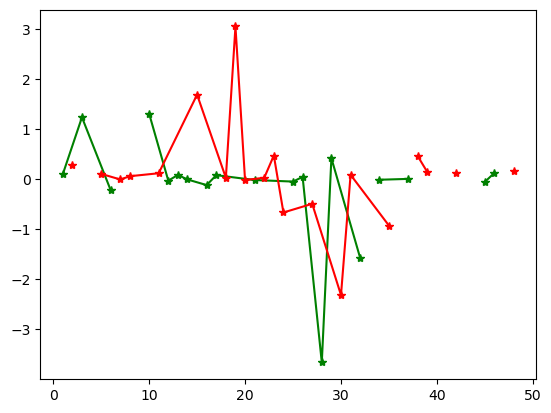

In [89]:
plt.plot(df_comb[df_comb['TrialDemandLearning']=="Easy"]['TrialN'], df_comb[df_comb['TrialDemandLearning']=="Easy"]['zyg_zvalues'], 'g*-')
plt.plot(df_comb[df_comb['TrialDemandLearning']=="Hard"]['TrialN'], df_comb[df_comb['TrialDemandLearning']=="Hard"]['zyg_zvalues'], 'r*-')

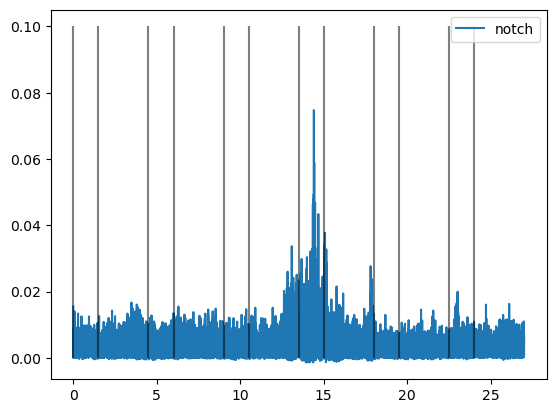

In [126]:
# lab = label.variables['label'].values[:,0,0]
# sig_emg = emg.variables['zyg'].values[:,0,0]
# sig_bandpass = bandpass.variables['zyg_IIRFilter'].values[:,0,0]
sig_notch = notch.variables['zyg_IIRFilter_NotchFilter'].values[:,0,0]
# plt.plot(sig_emg, alpha=0.4, label='raw')
# plt.plot(sig_bandpass, alpha=0.5, label='bandpass')
plt.plot(notch['time'].values, sig_notch, alpha=1, label='notch')
plt.vlines(df_res['time_start'],0, 0.1, colors='black', alpha=0.5)
plt.legend()

# Labsearning Phase

In [45]:
# df_learning

# True Choice Phase

In [63]:
# df_choice_true.Trial_N.value_counts()

# False Choice Phase

In [64]:
# set(df_choice_false.Trial_N)

# Offline Ratings

In [ ]:
df_offlines['Timepoint'] = df_offlines['Phase'].str[-2:]

# Learning Checks

In [ ]:
df_learning_checks['Timepoint'] = df_learning_checks['Phase'].str[-2:]